In [2]:
import ssl
# ─── SSL workaround for macOS certificate issues ───
try:
    _ctx = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _ctx

In [3]:
import nltk
# Force‐download the resources if missing
nltk.download('punkt',     quiet=True, force=True)
nltk.download('stopwords', quiet=True, force=True)
nltk.download('wordnet',   quiet=True, force=True)
import tensorflow as tf
# Enable GPU memory growth (if GPUs are available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" GPU acceleration is enabled.")
    except RuntimeError as e:
        print(e)

In [4]:
import shutil
import nltk

# Step 1: Manually remove old punkt data (if exists)
shutil.rmtree('/root/nltk_data/tokenizers/punkt', ignore_errors=True)

# Step 2: Redownload clean punkt data
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arjungyawali/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arjungyawali/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arjungyawali/nltk_data...


True

In [5]:
# 0) Silence JAX/XLA plugin errors (optional)
import os
os.environ['JAX_PLUGINS'] = ''

# 1) Imports
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split


In [6]:
# 1) Load all your raw CSVs and concatenate
df_train = pd.read_csv("train_movie_review.csv")

# 1) 80/20 train–test split
train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42)

# 3) (Optional) carve out 10% of that train for validation
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


print("Train columns:", train_df.columns)

Train columns: Index(['review', 'sentiment'], dtype='object')


In [7]:
# 4) NLTK setup (run once)
nltk.download('stopwords', force=True)
nltk.download('punkt',      force=True)
nltk.download('wordnet',    force=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arjungyawali/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arjungyawali/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arjungyawali/nltk_data...


In [8]:
# 5) Contractions map & expander
CONTRACTION_MAP = {
    "don't": "do not",
    "can't": "cannot",
    "i'm": "i am",
    "it's": "it is",
    "won't": "will not",
    "didn't": "did not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "couldn't": "could not",
    # add more entries as needed
}
_contraction_re = re.compile('(' + '|'.join(map(re.escape, CONTRACTION_MAP.keys())) + ')')

def expand_contractions(text: str) -> str:
    return _contraction_re.sub(lambda m: CONTRACTION_MAP[m.group(0)], text)

In [9]:
# 6) Text cleaning function
def clean_text(text):
    text = str(text)
    # a) Expand contractions
    text = expand_contractions(text)
    # b) Lowercase
    text = text.lower()
    # c) Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|https\S+",     "", text)
    text = re.sub(r"@\w+|#",                      "", text)
    # d) Keep letters & spaces only
    text = re.sub(r"[^a-z\s]",                    "", text)
    # e) Tokenize → remove stopwords → lemmatize
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    return " ".join(tokens)


In [10]:
# 7) Apply cleaning
train_df['cleaned_text'] = train_df['review'].apply(clean_text)
val_df  ['cleaned_text'] = val_df  ['review'].apply(clean_text)
test_df ['cleaned_text'] = test_df ['review'].apply(clean_text)

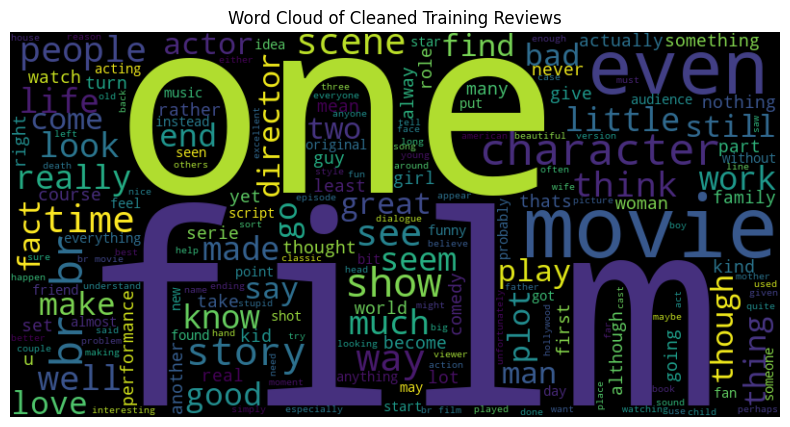

In [11]:
# 8) Visualize with WordCloud
all_words = ' '.join(train_df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Training Reviews")
plt.show()

In [12]:
# 9) Tokenization (train+val)
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([train_df['cleaned_text'], val_df['cleaned_text']]))

X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_val_seq   = tokenizer.texts_to_sequences(val_df  ['cleaned_text'])
X_test_seq  = tokenizer.texts_to_sequences(test_df ['cleaned_text'])

In [13]:
# 10) Padding (95th percentile length)
max_len = int(np.percentile([len(seq) for seq in X_train_seq], 95))
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val   = pad_sequences(X_val_seq,   maxlen=max_len, padding='post')
X_test  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post')

In [14]:
# 11) Labels
y_train = train_df['sentiment'].values
y_val   = val_df  ['sentiment'].values
y_test  = test_df ['sentiment'].values

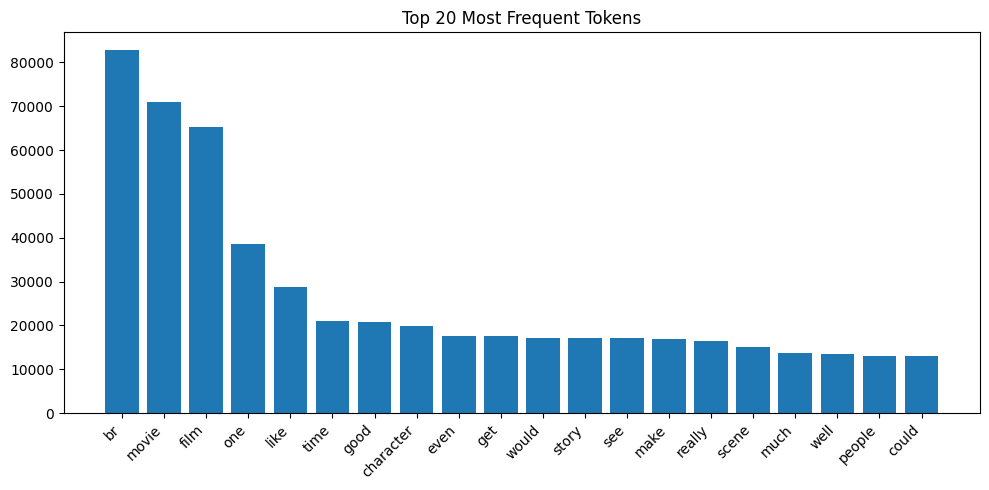

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

# flatten tokens from cleaned training text
all_tokens = [tok
    for doc in train_df['cleaned_text'].str.split()
    for tok in doc]

# count & pick top 20
top20 = Counter(all_tokens).most_common(20)
words, counts = zip(*top20)

# bar chart
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Tokens")
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt
import time
import glob
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import gensim.downloader as api
import numpy as np

In [19]:
# Assuming tokenizer, X_train, y_train, X_val, y_val, max_len are already defined

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

In [31]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# -------------------------------
# Model 1: Simple RNN
# -------------------------------
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

# Save Model 1
model_rnn.save("model_rnn.keras")

# -------------------------------
# Model 2: LSTM
# -------------------------------
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

# Save Model 2
model_lstm.save("model_lstm.keras")

# -------------------------------
# Model 3: LSTM + Pretrained Word2Vec
# -------------------------------
# Load GloVe embeddings
embedding_model = api.load("glove-wiki-gigaword-50")
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

model_w2v = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_w2v = model_w2v.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

# Save Model 3
model_w2v.save("model_w2v.keras")

Epoch 1/15


/Users/arjungyawali/Desktop/Text Classification/movie_review/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 79s 70ms/step - accuracy: 0.5009 - loss: 0.6964 - val_accuracy: 0.5153 - val_loss: 0.6928
Epoch 2/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.5037 - loss: 0.6948 - val_accuracy: 0.4902 - val_loss: 0.6945
Epoch 3/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 108s 96ms/step - accuracy: 0.5149 - loss: 0.6883 - val_accuracy: 0.4880 - val_loss: 0.6951
Epoch 4/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 110s 98ms/step - accuracy: 0.5227 - loss: 0.6697 - val_accuracy: 0.4877 - val_loss: 0.7081
Epoch 1/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 204s 181ms/step - accuracy: 0.4993 - loss: 0.6934 - val_accuracy: 0.5110 - val_loss: 0.6938
Epoch 2/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 223s 198ms/step - accuracy: 0.5072 - loss: 0.6921 - val_accuracy: 0.4888 - val_loss: 0.6926
Epoch 3/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 226s 201ms/step - accuracy: 0.5279 - loss: 0.6749 - val_accuracy: 0.5205 - val_loss: 0.7071
Epoch 4/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 203s 180ms/step - accuracy: 0.5332 -

In [33]:
# Save tokenizer for inference
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as tokenizer.pkl")

Tokenizer saved as tokenizer.pkl


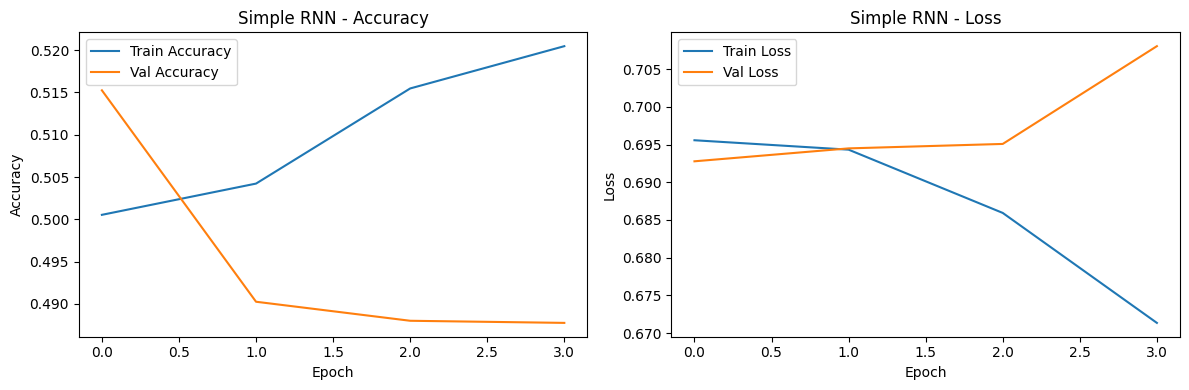

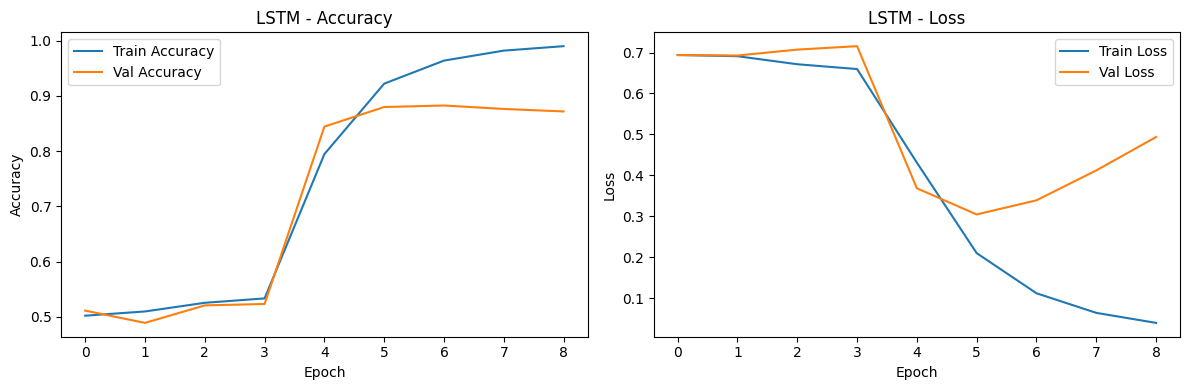

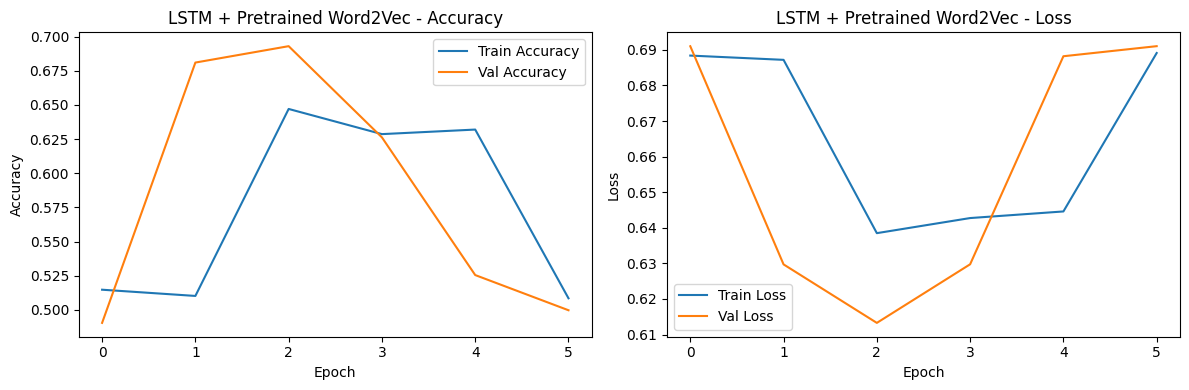

In [34]:
# ───────────────────────────────────────────────
# Visualization: Training vs. Validation loss and accuracy
# ───────────────────────────────────────────────
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # Plot training histories
plot_training_history(history_rnn, "Simple RNN")
plot_training_history(history_lstm, "LSTM")
plot_training_history(history_w2v, "LSTM + Pretrained Word2Vec")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
🔍 Simple RNN Accuracy: 0.5087

Classification Report for Simple RNN:
               precision    recall  f1-score   support

           0       0.51      0.98      0.67      5057
           1       0.55      0.03      0.06      4943

    accuracy                           0.51     10000
   macro avg       0.53      0.50      0.36     10000
weighted avg       0.53      0.51      0.37     10000



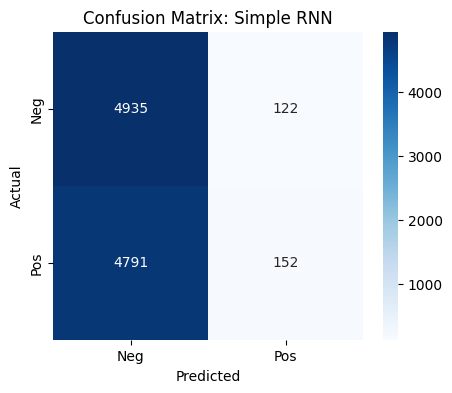

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
🔍 LSTM Accuracy: 0.8779

Classification Report for LSTM:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5057
           1       0.87      0.88      0.88      4943

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



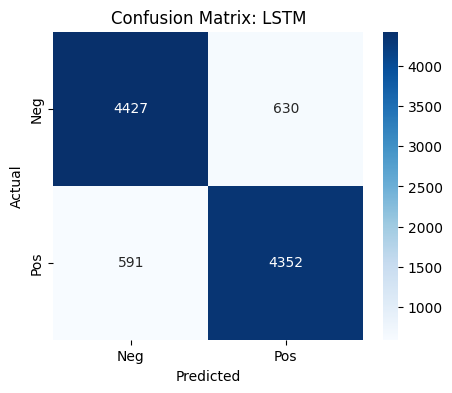

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
🔍 LSTM + Word2Vec Accuracy: 0.6871

Classification Report for LSTM + Word2Vec:
               precision    recall  f1-score   support

           0       0.66      0.80      0.72      5057
           1       0.74      0.57      0.64      4943

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.68     10000
weighted avg       0.70      0.69      0.68     10000



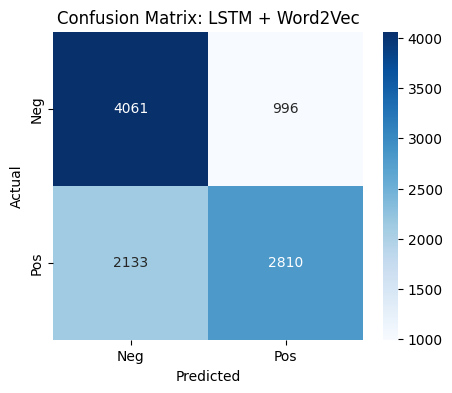

In [35]:
# ───────────────────────────────────────────────
# Model Evaluation: Accuracy, Confusion Matrix, Classification Report
# ───────────────────────────────────────────────
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, X, y, model_name):
    y_pred = (model.predict(X) > 0.5).astype(int)
    acc = accuracy_score(y, y_pred)
    print(f"🔍 {model_name} Accuracy: {acc:.4f}")
    print(f"\nClassification Report for {model_name}:\n", classification_report(y, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return acc
# Evaluate on test set
acc_rnn  = evaluate_model(model_rnn,  X_test, y_test, "Simple RNN")
acc_lstm = evaluate_model(model_lstm, X_test, y_test, "LSTM")
acc_w2v  = evaluate_model(model_w2v,  X_test, y_test, "LSTM + Word2Vec")

/var/folders/4h/9wzcc04x59n3bqs35drjz7tr0000gn/T/ipykernel_92323/1690027207.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


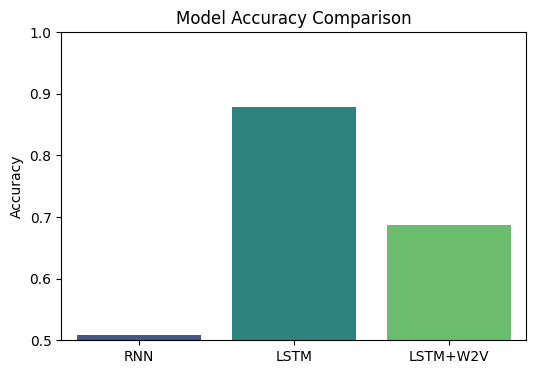

In [36]:
# ───────────────────────────────────────────────
# Compare Model Accuracies
# ───────────────────────────────────────────────
plt.figure(figsize=(6,4))
model_names = ["RNN", "LSTM", "LSTM+W2V"]
accuracies = [acc_rnn, acc_lstm, acc_w2v]
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.show()

In [1]:
!pwd
!ls

/Users/arjungyawali/Desktop/Text Classification/notebook
inference.py           model_w2v.keras        train_model.ipynb
model_lstm.keras       sentiment_analyzer.py  train_movie_review.csv
model_rnn.keras        tokenizer.pkl


In [5]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from colorama import init, Fore, Style
from tabulate import tabulate

# Initialize colorama for colored output
init()

def load_models_and_tokenizer():
    """Load all models and tokenizer with proper error handling."""
    # Load tokenizer
    try:
        with open("tokenizer.pkl", "rb") as f:
            tokenizer = pickle.load(f)
        print(f"{Fore.GREEN}Successfully loaded tokenizer{Style.RESET_ALL}")
    except FileNotFoundError:
        print(f"{Fore.RED}Error: tokenizer.pkl not found!{Style.RESET_ALL}")
        return None, None

    # Define model paths
    model_paths = {
        "RNN": "model_rnn.keras",
        "LSTM": "model_lstm.keras",
        "LSTM+W2V": "model_w2v.keras"
    }

    # Load models
    models = {}
    for name, path in model_paths.items():
        try:
            if not os.path.exists(path):
                print(f"{Fore.YELLOW}Warning: {path} not found. Skipping {name} model.{Style.RESET_ALL}")
                continue
            models[name] = load_model(path)
            print(f"{Fore.GREEN}Successfully loaded {name} model{Style.RESET_ALL}")
        except Exception as e:
            print(f"{Fore.RED}Error loading {name} model: {str(e)}{Style.RESET_ALL}")

    if not models:
        print(f"{Fore.RED}Error: No models were successfully loaded!{Style.RESET_ALL}")
        return None, None

    return models, tokenizer

def preprocess_text(text: str) -> str:
    """Clean and preprocess the input text."""
    # Initialize NLTK components
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Clean text
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize and lemmatize
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    
    return " ".join(tokens)

def predict_sentiment(text: str, models: dict, tokenizer, max_len: int = 200) -> dict:
    """Predict sentiment using all available models."""
    # Preprocess text
    cleaned_text = preprocess_text(text)
    
    # Convert to sequence and pad
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    
    # Get predictions
    predictions = {}
    for name, model in models.items():
        prob = model.predict(padded, verbose=0)[0][0]
        label = "Positive" if prob >= 0.5 else "Negative"
        confidence = float(prob) if label == "Positive" else 1 - float(prob)
        predictions[name] = {
            "label": label,
            "confidence": confidence,
            "raw_probability": float(prob)
        }
    
    return predictions

def display_predictions(text: str, predictions: dict):
    """Display predictions in a formatted table."""
    print(f"\n{Fore.CYAN}{'='*80}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}Input Text:{Style.RESET_ALL}")
    print(f"{Fore.WHITE}{text}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}{'='*80}{Style.RESET_ALL}")
    
    # Prepare table data
    table_data = []
    for model_name, pred in predictions.items():
        confidence = pred['confidence']
        color = Fore.GREEN if pred['label'] == "Positive" else Fore.RED
        table_data.append([
            model_name,
            f"{color}{pred['label']}{Style.RESET_ALL}",
            f"{confidence:.2%}"
        ])
    
    # Display table
    headers = ["Model", "Sentiment", "Confidence"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print(f"{Fore.CYAN}{'='*80}{Style.RESET_ALL}\n")

def main():
    """Main function to run the sentiment analysis."""
    print(f"{Fore.CYAN}Loading models and tokenizer...{Style.RESET_ALL}")
    models, tokenizer = load_models_and_tokenizer()
    
    if models is None or tokenizer is None:
        return

    print(f"\n{Fore.CYAN}Sentiment Analysis Ready!{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Enter 'quit' to exit{Style.RESET_ALL}")
    
    while True:
        try:
            # Get user input
            user_input = input(f"\n{Fore.GREEN}Enter your text:{Style.RESET_ALL} ")
            
            if user_input.lower() == 'quit':
                print(f"\n{Fore.CYAN}Thank you for using the Sentiment Analyzer!{Style.RESET_ALL}")
                break
            
            if not user_input.strip():
                print(f"{Fore.YELLOW}Please enter some text to analyze.{Style.RESET_ALL}")
                continue
            
            # Get and display predictions
            predictions = predict_sentiment(user_input, models, tokenizer)
            display_predictions(user_input, predictions)
            
        except KeyboardInterrupt:
            print(f"\n{Fore.CYAN}Thank you for using the Sentiment Analyzer!{Style.RESET_ALL}")
            break
        except Exception as e:
            print(f"{Fore.RED}Error: {str(e)}{Style.RESET_ALL}")

if __name__ == "__main__":
    main() 

Loading models and tokenizer...
Successfully loaded tokenizer
Successfully loaded RNN model
Successfully loaded LSTM model
Successfully loaded LSTM+W2V model

Sentiment Analysis Ready!
Enter 'quit' to exit

Input Text:
I loved this movie
+----------+-------------+--------------+
| Model    | Sentiment   | Confidence   |
+==========+=============+==============+
| RNN      | Negative    | 50.60%       |
+----------+-------------+--------------+
| LSTM     | Positive    | 61.08%       |
+----------+-------------+--------------+
| LSTM+W2V | Positive    | 73.96%       |
+----------+-------------+--------------+


Thank you for using the Sentiment Analyzer!


In [17]:
!pip install gradio nltk tensorflow numpy matplotlib

import numpy as np
import tensorflow as tf
import gradio as gr
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# ————————————————————————————————
# 1) MODEL + TOKENIZER LOADING
# ————————————————————————————————
from pathlib import Path

try:
    BASE = Path(__file__).parent
except NameError:
    BASE = Path().resolve()

print("Loading from:", BASE)

with open(BASE / "tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

model_rnn  = tf.keras.models.load_model(str(BASE / "model_rnn.keras"))
model_lstm = tf.keras.models.load_model(str(BASE / "model_lstm.keras"))
model_w2v  = tf.keras.models.load_model(str(BASE / "model_w2v.keras"))

MAX_LEN = 100
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

CONTRACTION_MAP = {
    "don't": "do not", "can't": "cannot", "i'm": "i am", "it's": "it is",
    "won't": "will not", "didn't": "did not", "doesn't": "does not",
    "isn't": "is not", "aren't": "are not", "couldn't": "could not",
}
_contraction_re = re.compile("(" + "|".join(map(re.escape, CONTRACTION_MAP.keys())) + ")")

def expand_contractions(text):
    return _contraction_re.sub(lambda m: CONTRACTION_MAP[m.group(0)], text)

def clean_text(text: str) -> str:
    text = expand_contractions(text.lower())
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    return " ".join(tokens)

def create_sentiment_plot(results: dict):
    models = list(results.keys())
    probs  = [results[m]["raw_probability"] for m in models]
    colors = ['green' if p>=0.5 else 'red' for p in probs]

    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.barh(models, probs, color=colors)
    ax.axvline(0.5, color='gray', ls='--', alpha=0.7)
    for bar, p in zip(bars, probs):
        lbl = "Positive" if p>=0.5 else "Negative"
        ax.text(p+0.01, bar.get_y()+bar.get_height()/2,
                f"{lbl} ({p:.2f})", va='center')
    ax.set_xlim(0,1)
    ax.set_xlabel("Probability of Positive Sentiment")
    ax.set_title("Sentiment Analysis Results")
    plt.tight_layout()
    return fig

def predict_sentiment(review, include_analysis):
    if not review or not review.strip():
        return {}, None, "❗ Please enter some text."

    c = clean_text(review)
    seq = tokenizer.texts_to_sequences([c])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    out = {}
    for name, m in [("RNN Model", model_rnn), 
                    ("LSTM Model", model_lstm), 
                    ("Word2Vec + LSTM", model_w2v)]:
        p = float(m.predict(pad, verbose=0)[0][0])
        label = "Positive" if p>=0.5 else "Negative"
        conf  = p if p>=0.5 else 1-p
        out[name] = {
            "label": label,
            "confidence": f"{conf:.2%}",
            "raw_probability": p
        }

    fig = create_sentiment_plot(out)

    analysis = None
    if include_analysis:
        words = c.split()
        analysis = (
            f"**Original words:** {len(review.split())}\n\n"
            f"**After cleaning:** {len(words)}\n\n"
            f"**Unique words:** {len(set(words))}"
        )

    return out, fig, analysis

def load_example(i):
    examples = [
        "This movie was fantastic! The acting was superb and the plot kept me engaged.",
        "Terrible film. Bad acting, boring storyline, poor direction. Don't waste your time.",
        "It wasn't great, but it wasn't terrible either. Some good moments, overall average.",
        "The effects were amazing, but the plot made no sense and characters were flat.",
        "I've never seen anything like this before—a masterpiece that will be remembered."
    ]
    return examples[i]

# ————————————————————————————————
# 2) GRADIO INTERFACE
# ————————————————————————————————
with gr.Blocks(title="Movie Review Sentiment Analysis") as demo:
    gr.Markdown("""
    ## 🎬 Movie Review Sentiment Analysis

    This app analyzes the sentiment of movie reviews using three different deep learning models:
    - **RNN Model**  
    - **LSTM Model**  
    - **Word2Vec + LSTM**  

    A score above 0.5 is Positive, below 0.5 is Negative.
    """)

    with gr.Row():
        with gr.Column(scale=3):
            review_input = gr.Textbox(
                label="Movie Review",
                placeholder="Enter your review here...",
                lines=5
            )
            with gr.Row():
                submit_btn = gr.Button("Analyze Sentiment", variant="primary")
                clear_btn  = gr.Button("Clear")
            analyze_chk = gr.Checkbox("Include text analysis", value=False)
        with gr.Column(scale=1):
            gr.Markdown("### Example Reviews")
            for i, label in enumerate([
                "Positive Example",
                "Negative Example",
                "Mixed/Neutral Example",
                "Mixed with Positives",
                "Strongly Positive"
            ]):
                gr.Button(label).click(fn=lambda idx=i: load_example(idx),
                                      outputs=review_input)

    with gr.Tabs():
        with gr.TabItem("Results Visualization"):
            result_plot = gr.Plot()
        with gr.TabItem("Raw Results"):
            result_json = gr.JSON()
        with gr.TabItem("Text Analysis"):
            text_analysis = gr.Markdown()

    submit_btn.click(
        fn=predict_sentiment,
        inputs=[review_input, analyze_chk],
        outputs=[result_json, result_plot, text_analysis]
    )
    clear_btn.click(
        lambda: ({"RNN Model":"","LSTM Model":"","Word2Vec + LSTM":""}, None, ""),
        outputs=[result_json, result_plot, text_analysis]
    )

if __name__ == "__main__":
    demo.launch()



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Loading from: /Users/arjungyawali/Desktop/Text Classification/notebook
* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
